<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/TextClassifierDistilbertGerman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying News Articles with Distilbert

based on https://www.philschmid.de/bert-text-classification-in-a-different-language/ which applies `distilbert-base-german-cased` model on the [Germeval 2019](hhttps://projects.fzai.h-da.de/iggsa/projekt/) dataset to identify offensive language in German tweets.

Following we will use `distilbert-base-german-cased` on the 10k German News Articles dataset to classify 9 news topics.

## Prerequisites

In [38]:
# install simpletransformers
!pip install -q ipykernel==4.10 simpletransformers > /dev/null

# check installed version
!pip freeze | grep simpletransformers
# simpletransformers==0.61.4

simpletransformers==0.61.4


## Download Data

In [39]:
%env DIR=data

!mkdir -p $DIR
!wget -nc https://github.com/tblock/10kGNAD/blob/master/train.csv?raw=true -nv -O $DIR/train.csv
!wget -nc https://github.com/tblock/10kGNAD/blob/master/test.csv?raw=true -nv -O $DIR/test.csv
!ls -lAh $DIR | cut -d " " -f 5-

env: DIR=data

180K Apr 29 15:28 predictions.csv
2.7M Apr 29 14:51 test.csv
 24M Apr 29 14:51 train.csv


## Import Data

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [41]:
data_dir = Path("data/")

train_file = data_dir / 'train.csv'
test_file = data_dir / 'test.csv'

In [42]:
def load_file(filepath: Path) -> pd.DataFrame:
    f = pd.read_csv(filepath, sep=";", quotechar="'", names=['labels', 'text'])
    return f

In [43]:
train_df = load_file(data_dir / 'train.csv')
print(train_df.shape[0], 'articles')
display(train_df.head())

9245 articles


,labels,text
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,Inland,Estland sieht den künftigen österreichischen P...


## Analyse Dataset

* Imbalanced classes
* Text length

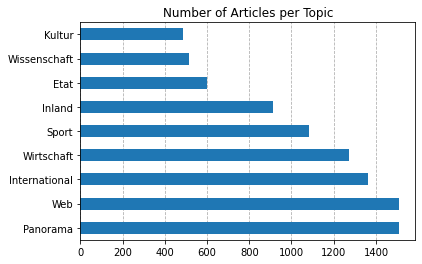

In [44]:
train_df.labels.value_counts().plot.barh(title="Number of Articles per Topic", zorder=2)
plt.gca().xaxis.grid(True, linestyle='--');

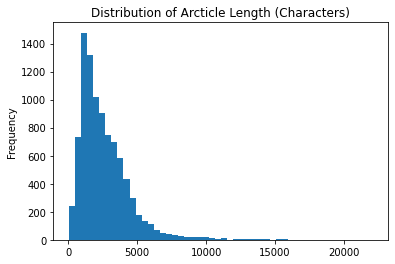

In [45]:
train_df.text.map(lambda x: len(x)).plot.hist(bins=50, title="Distribution of Arcticle Length (Characters)");

## Prepare for Model Training

Requirements of SimpleTransformers

* columns should be labeled `labels` and `text`
* labels must be int values starting at `0`

In [46]:
# compute weights for training (where least frequent class has weight 1.0)
train_weights_s = (train_df
                   .labels
                   .value_counts()
                   .pipe(lambda x: 1 / (x / x.min()))
)
train_weights_s

Panorama         0.321192
Web              0.321405
International    0.356618
Wirtschaft       0.381890
Sport            0.448659
Inland           0.531216
Etat             0.806988
Wissenschaft     0.939922
Kultur           1.000000
Name: labels, dtype: float64

In [47]:
# map label to integers
mapping_s = pd.Series(train_weights_s.index)
mapping_s

0         Panorama
1              Web
2    International
3       Wirtschaft
4            Sport
5           Inland
6             Etat
7     Wissenschaft
8           Kultur
dtype: object

In [48]:
# truncate text
#train_df.text = train_df.text.map(lambda x: x[:2000])

In [49]:
train_df.labels.replace(mapping_s.values, mapping_s.index, inplace=True)
display(train_df.head())

,labels,text
0,4,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,8,"Erfundene Bilder zu Filmen, die als verloren g..."
2,1,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,3,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,5,Estland sieht den künftigen österreichischen P...


In [50]:
# load test dataset
test_df = load_file(data_dir / 'test.csv')
test_df.labels.replace(mapping_s.values, mapping_s.index, inplace=True)
print(test_df.shape[0], 'articles')
display(test_df.head())

1028 articles


,labels,text
0,3,"Die Gewerkschaft GPA-djp lanciert den ""All-in-..."
1,4,Franzosen verteidigen 2:1-Führung – Kritische ...
2,1,Neues Video von Designern macht im Netz die Ru...
3,4,23-jähriger Brasilianer muss vier Spiele pausi...
4,2,Aufständische verwendeten Chemikalie bei Gefec...


## Train Model

In [51]:
import wandb

# initialize weights & biases logging
project_name = "german_news_article_classification"

In [52]:
from simpletransformers.classification import ClassificationModel

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "fp16": False,
             "num_train_epochs": 4,
             "weight": train_weights_s.values,
             "evaluate_during_training": True,
             "overwrite_output_dir": True,
             "wandb_project": project_name}

# Create a ClassificationModel
model = ClassificationModel(
     "bert", "bert-base-german-cased",
    #  "bert", "bert-base-multilingual-cased",
    #  "distilbert", "distilbert-base-german-cased",
    #  "distilbert", "distilbert-base-multilingual-cased",
    # "distilbert", "dbmdz/distilbert-base-german-europeana-cased",
    # "electra", "german-nlp-group/electra-base-german-uncased", # ---
    # "electra", "deepset/gelectra-large",
     num_labels=9,
     args=train_args
 )

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

Downloading:   0%|          | 0.00/255k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/485k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [53]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')

def precision_multiclass(labels, preds):
    return precision_score(labels, preds, average='macro')

def recall_multiclass(labels, preds):
    return recall_score(labels, preds, average='macro')

In [54]:
model.train_model(train_df, eval_df=test_df, f1=f1_multiclass, acc=accuracy_score, precision=precision_multiclass, recall=recall_multiclass);

  0%|          | 0/9245 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

wandb: Currently logged in as: goerlitz (use `wandb login --relogin` to force relogin)


Running Epoch 0 of 4:   0%|          | 0/1156 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1156 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1156 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1156 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

In [55]:
result, model_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score, precision=precision_multiclass, recall=recall_multiclass)

wandb.join()
wandb.finish()

  0%|          | 0/1028 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/129 [00:00<?, ?it/s]

Training loss,0.94473
lr,0.0
global_step,4624
_runtime,2130
_timestamp,1619713150
_step,97
mcc,0.87521
train_loss,0.00077
eval_loss,0.64644
f1,0.88838
acc,0.89105


Training loss,█▂▃▄▅▂▂▄▄▂▁▁▃▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄
lr,▂▅▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
mcc,▄▁█▆▇█
train_loss,█▁▂▁▁▁
eval_loss,▁▄▂▇██
f1,▄▁█▇▇█
acc,▄▁█▆▇█


_runtime,11
_timestamp,1619713185
_step,2


_runtime,▁▅█
_timestamp,▁▅█
_step,▁▅█


In [56]:
pd.Series(result)

mcc          0.875212
f1           0.888382
acc          0.891051
precision    0.888146
recall       0.889573
eval_loss    0.646436
dtype: float64

In [57]:
preds = pd.DataFrame(model_outputs, columns=mapping_s)
preds

,Panorama,Web,International,Wirtschaft,Sport,Inland,Etat,Wissenschaft,Kultur
0,-2.013780,-1.972787,-1.387380,7.902581,-1.552896,2.056303,-0.574623,-1.002868,-1.837404
1,-1.656207,-1.020337,-1.208633,-0.478263,9.825918,-1.850674,-1.110685,-1.147422,-0.459407
2,-1.663723,9.430115,-1.283884,-1.626543,-1.124974,-1.246142,-0.794099,-0.822364,-1.492260
3,-1.331890,-1.113748,-0.954237,-0.710391,9.789900,-1.891886,-1.205703,-1.104747,-0.767286
4,0.261449,-0.682691,9.010175,-0.383927,-1.776632,-2.408924,-1.130090,-1.857046,-1.639266
...,...,...,...,...,...,...,...,...,...
1023,-1.686842,9.371931,-1.337412,-1.318443,-1.201945,-1.112578,-0.545908,-1.035278,-1.767063
1024,-0.748472,-1.710980,-1.559966,-0.723445,-1.567009,8.403862,-0.300035,-1.464531,-1.259340
1025,-1.501304,-1.119264,-1.505351,-0.444185,9.793852,-1.760599,-1.155419,-1.044753,-0.543628
1026,-1.525224,-1.172442,-1.410674,-0.631389,9.801750,-1.773232,-1.200067,-0.938272,-0.265135


In [58]:
preds.to_csv("data/predictions.csv", index=False)

In [59]:
!cp data/predictions.csv "/content/gdrive/My Drive/Colab Notebooks/nlp-classification/"

In [60]:
pred_s = pd.DataFrame(model_outputs).idxmax(axis=1)
test_df.labels

0       3
1       4
2       1
3       4
4       2
       ..
1023    1
1024    5
1025    4
1026    4
1027    1
Name: labels, Length: 1028, dtype: int64

In [61]:
mapping_s.values

array(['Panorama', 'Web', 'International', 'Wirtschaft', 'Sport',
       'Inland', 'Etat', 'Wissenschaft', 'Kultur'], dtype=object)

In [62]:
import sklearn.metrics as skm
skm.confusion_matrix(test_df.labels, pred_s)

array([[137,   1,  10,   3,   0,   8,   1,   6,   2],
       [  1, 166,   0,   0,   0,   0,   1,   0,   0],
       [ 13,   0, 129,   5,   1,   0,   2,   1,   0],
       [  9,   2,   1, 123,   0,   6,   0,   0,   0],
       [  0,   0,   0,   1, 119,   0,   0,   0,   0],
       [  5,   0,   2,   5,   0,  85,   1,   2,   2],
       [  4,   2,   1,   1,   0,   0,  57,   0,   2],
       [  1,   0,   1,   1,   0,   1,   0,  53,   0],
       [  1,   0,   2,   0,   0,   1,   1,   2,  47]])

In [63]:
print(skm.classification_report(test_df.labels, pred_s, target_names=mapping_s.values))

               precision    recall  f1-score   support

     Panorama       0.80      0.82      0.81       168
          Web       0.97      0.99      0.98       168
International       0.88      0.85      0.87       151
   Wirtschaft       0.88      0.87      0.88       141
        Sport       0.99      0.99      0.99       120
       Inland       0.84      0.83      0.84       102
         Etat       0.90      0.85      0.88        67
 Wissenschaft       0.83      0.93      0.88        57
       Kultur       0.89      0.87      0.88        54

     accuracy                           0.89      1028
    macro avg       0.89      0.89      0.89      1028
 weighted avg       0.89      0.89      0.89      1028



In [64]:
result, model_outputs, wrong_predictions

({'acc': 0.8910505836575876,
  'eval_loss': 0.6464357182461148,
  'f1': 0.8883816460789804,
  'mcc': 0.8752115880344686,
  'precision': 0.8881459708225063,
  'recall': 0.8895730766995033},
 array([[-2.01378036, -1.97278666, -1.38738024, ..., -0.57462263,
         -1.00286841, -1.83740366],
        [-1.65620744, -1.0203371 , -1.20863318, ..., -1.11068475,
         -1.14742172, -0.45940733],
        [-1.66372323,  9.43011475, -1.28388417, ..., -0.79409945,
         -0.82236439, -1.49225998],
        ...,
        [-1.50130379, -1.11926365, -1.50535119, ..., -1.15541935,
         -1.04475284, -0.54362804],
        [-1.52522361, -1.1724422 , -1.41067374, ..., -1.20006692,
         -0.9382723 , -0.26513493],
        [-1.64698267,  9.36084652, -1.31671822, ..., -0.6558522 ,
         -0.78607851, -1.46170831]]),
 [])

In [65]:
len(wrong_predictions)

0

In [66]:
pred, output = model.predict(["Hallo Welt"])
pred

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[4]

In [67]:
pd.DataFrame(model_outputs).apply(max, axis=1)

0       7.902581
1       9.825918
2       9.430115
3       9.789900
4       9.010175
          ...   
1023    9.371931
1024    8.403862
1025    9.793852
1026    9.801750
1027    9.360847
Length: 1028, dtype: float64

In [68]:
!ls -lah outputs/best_model

total 1.3G
drwxr-xr-x 2 root root 4.0K Apr 29 14:56 .
drwxr-xr-x 9 root root 4.0K Apr 29 15:10 ..
-rw-r--r-- 1 root root 1006 Apr 29 15:52 config.json
-rw-r--r-- 1 root root  163 Apr 29 15:52 eval_results.txt
-rw-r--r-- 1 root root 2.6K Apr 29 15:52 model_args.json
-rw-r--r-- 1 root root 833M Apr 29 15:52 optimizer.pt
-rw-r--r-- 1 root root 417M Apr 29 15:52 pytorch_model.bin
-rw-r--r-- 1 root root  623 Apr 29 15:52 scheduler.pt
-rw-r--r-- 1 root root  112 Apr 29 15:52 special_tokens_map.json
-rw-r--r-- 1 root root  291 Apr 29 15:52 tokenizer_config.json
-rw-r--r-- 1 root root 3.5K Apr 29 15:52 training_args.bin
-rw-r--r-- 1 root root 249K Apr 29 15:52 vocab.txt


In [69]:
from google.colab import drive

In [70]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [71]:
#!cp -r outputs/best_model "/content/gdrive/My Drive/Colab Notebooks/nlp-classification/model/best_model"